In [711]:
import opendatasets as od
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline 
from sklearn.model_selection import GridSearchCV



In [712]:
dataset_url = 'https://www.kaggle.com/competitions/classification-of-oil-and-gas-fields'
od.download(dataset_url)


Skipping, found downloaded files in "./classification-of-oil-and-gas-fields" (use force=True to force download)


In [713]:
dfTrain = pd.read_csv('./classification-of-oil-and-gas-fields/train_oil.csv')
dfTest = pd.read_csv('./classification-of-oil-and-gas-fields/oil_test.csv')
dfTrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Field name                      309 non-null    object 
 1   Reservoir unit                  309 non-null    object 
 2   Country                         282 non-null    object 
 3   Region                          271 non-null    object 
 4   Basin name                      271 non-null    object 
 5   Tectonic regime                 309 non-null    object 
 6   Latitude                        282 non-null    float64
 7   Longitude                       279 non-null    float64
 8   Operator company                309 non-null    object 
 9   Onshore/Offshore                309 non-null    object 
 10  Hydrocarbon type                309 non-null    object 
 11  Reservoir status                309 non-null    object 
 12  Structural setting              309 

In [714]:
for col in dfTrain:
    print(f'Уникальных значений в колонки [{col}] {len(dfTrain[col].unique())} из {dfTrain.shape[0]} {(dfTrain.shape[0] / len(dfTrain[col].unique())):.2f}')

Уникальных значений в колонки [Field name] 285 из 309 1.08
Уникальных значений в колонки [Reservoir unit] 258 из 309 1.20
Уникальных значений в колонки [Country] 43 из 309 7.19
Уникальных значений в колонки [Region] 8 из 309 38.62
Уникальных значений в колонки [Basin name] 94 из 309 3.29
Уникальных значений в колонки [Tectonic regime] 55 из 309 5.62
Уникальных значений в колонки [Latitude] 263 из 309 1.17
Уникальных значений в колонки [Longitude] 261 из 309 1.18
Уникальных значений в колонки [Operator company] 138 из 309 2.24
Уникальных значений в колонки [Onshore/Offshore] 3 из 309 103.00
Уникальных значений в колонки [Hydrocarbon type] 4 из 309 77.25
Уникальных значений в колонки [Reservoir status] 13 из 309 23.77
Уникальных значений в колонки [Structural setting] 43 из 309 7.19
Уникальных значений в колонки [Depth] 279 из 309 1.11
Уникальных значений в колонки [Reservoir period] 22 из 309 14.05
Уникальных значений в колонки [Lithology] 13 из 309 23.77
Уникальных значений в колонки [

In [715]:

feature = ['Country', 'Region', 'Basin name', 'Tectonic regime', 'Latitude', 'Longitude', 'Hydrocarbon type', 'Structural setting', 'Depth', 'Reservoir period', 'Lithology', 'Thickness (gross average ft)', 'Thickness (net pay average ft)', 'Porosity', 'Permeability']
target = ['Onshore/Offshore']

dfTrain = dfTrain[dfTrain['Onshore/Offshore'] != 'ONSHORE-OFFSHORE']

# TODO Потом разобраться как сделать правильно
# dfTrain['Onshore/Offshore'] = dfTrain['Onshore/Offshore'].str.split('-')

# выделяем признаки и таргет
X = dfTrain[feature]
y = dfTrain[target].values.ravel()
# dfTrain

In [716]:
# Фильтруем только столбцы с пропусками
missing_values = X.isna().sum()

# Фильтруем только столбцы с пропусками
columns_with_missing = missing_values[missing_values > 0]
columns_with_missing

Country       26
Region        37
Basin name    37
Latitude      26
Longitude     29
dtype: int64

In [717]:
unique, counts = np.unique(y, return_counts=True)
np.asarray((unique, counts)).T

array([['OFFSHORE', 86],
       ['ONSHORE', 218]], dtype=object)

In [718]:
X.head(2)

,Country,Region,Basin name,Tectonic regime,Latitude,Longitude,Hydrocarbon type,Structural setting,Depth,Reservoir period,Lithology,Thickness (gross average ft),Thickness (net pay average ft),Porosity,Permeability
0,RUSSIA,FORMER SOVIET UNION,VOLGA-URAL,COMPRESSION/EVAPORITE,51.0000,44.8042,OIL,FORELAND,1870,CARBONIFEROUS,SANDSTONE,262.0,33.0,24.0,30.0
1,BRAZIL,LATIN AMERICA,ESPIRITO SANTO,EXTENSION,-19.6017,-39.8332,OIL,PASSIVE MARGIN,4843,PALEOGENE,SANDSTONE,2133.0,72.0,23.0,350.0


In [719]:
# числовые фичи
numeric_features = ["Latitude", "Longitude", "Thickness (gross average ft)", "Thickness (net pay average ft)", "Porosity", "Permeability"]

numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median"))
    ]
)

# категориальные фичи
categorical_features = [
  "Country", "Region", "Basin name", "Tectonic regime", "Hydrocarbon type", "Structural setting", "Reservoir period", "Lithology" ]
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")), 
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
        ("selector", SelectPercentile(chi2, percentile=50)),
    ]
)


# для последующей предобработки фичей разного типа
preprocessor = ColumnTransformer(
    transformers=[
        # ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
        
    ]
)


Возникла крайне необычная и непонятная ситуация. Какие бы попытки я ни предпринимал, при добавлении числовых параметров в расчеты итоговый результат неизменно снижался. Это происходило систематически, независимо от того, какие значения или методы я пробовал использовать. После многочисленных проверок и анализа стало очевидно, что включение этих параметров негативно влияет на конечный вывод. В связи с этим было принято решение исключить их из финальной версии, чтобы избежать искажения данных и получить более точные и достоверные результаты

In [ ]:
# Разделение данных и обучение модели
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=55, stratify=y)

clf = ImbPipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("resampler", SMOTE(random_state=42)),
        ("classifier", None) 
    ]
)

# Сетки параметров для разных моделей
param_grids = [
    # Logistic Regression
    {
        'classifier': [LogisticRegression(solver='liblinear', random_state=42)],
        'classifier__penalty': ['l1', 'l2'],
        'classifier__C': [0.01, 0.1, 1, 10, 100],
        'classifier__max_iter': [100, 500, 1000],
        'classifier__class_weight': [None, 'balanced'],
        'resampler__k_neighbors': [3, 5, 7] 
    },
    
    # Random Forest
    {
        'classifier': [RandomForestClassifier(random_state=42)],
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [None, 5, 10],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__class_weight': [None, 'balanced'],
        'resampler__k_neighbors': [3, 5, 7] 
    },
    
    # SVM (линейный)
    {
        'classifier': [SVC(random_state=42, probability=True)],
        'classifier__C': [0.1, 1, 10],
        'classifier__kernel': ['linear', 'rbf'],
        'classifier__gamma': ['scale', 'auto'],
        'classifier__class_weight': [None, 'balanced'],
        'resampler__k_neighbors': [3, 5, 7]
    },
]

# Настройка GridSearchCV
grid_search = GridSearchCV(
    clf,
    param_grids,
    cv=3,
    scoring='f1_weighted',
    n_jobs=-1,
    error_score='raise'
)

grid_search.fit(X_train, y_train)

# Лучшие параметры
print("Лучшие параметры:", grid_search.best_params_)
print("Лучшая оценка (F1):", grid_search.best_score_)

15763.00s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
15763.20s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
15763.41s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
15763.62s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
0.00

Лучшие параметры: {'classifier': SVC(probability=True, random_state=42), 'classifier__C': 1, 'classifier__class_weight': None, 'classifier__gamma': 'scale', 'classifier__kernel': 'linear', 'resampler__k_neighbors': 7}
Лучшая оценка (F1): 0.866428832230314


In [ ]:
# 1. Обучение лучшей модели на всех данных (X, y)
best_model = grid_search.best_estimator_
best_model.fit(X, y) 

# 2. Предсказание для тестового набора dfTest
y_test_pred = best_model.predict(dfTest)

# Преобразование строковых предсказаний в числа (0 или 1)
y_test_pred_numeric = [0 if pred == 'OFFSHORE' else 1 for pred in y_test_pred]

result_df = pd.DataFrame({
    "index": range(len(y_test_pred_numeric)), 
    "Onshore/Offshore": y_test_pred_numeric
})


result_df.to_csv("submission.csv", index=False)

print("Файл submission.csv успешно сохранен!")
result_df.head()

Файл submission.csv успешно сохранен!


,index,Onshore/Offshore
0,0,1
1,1,1
2,2,1
3,3,0
4,4,1


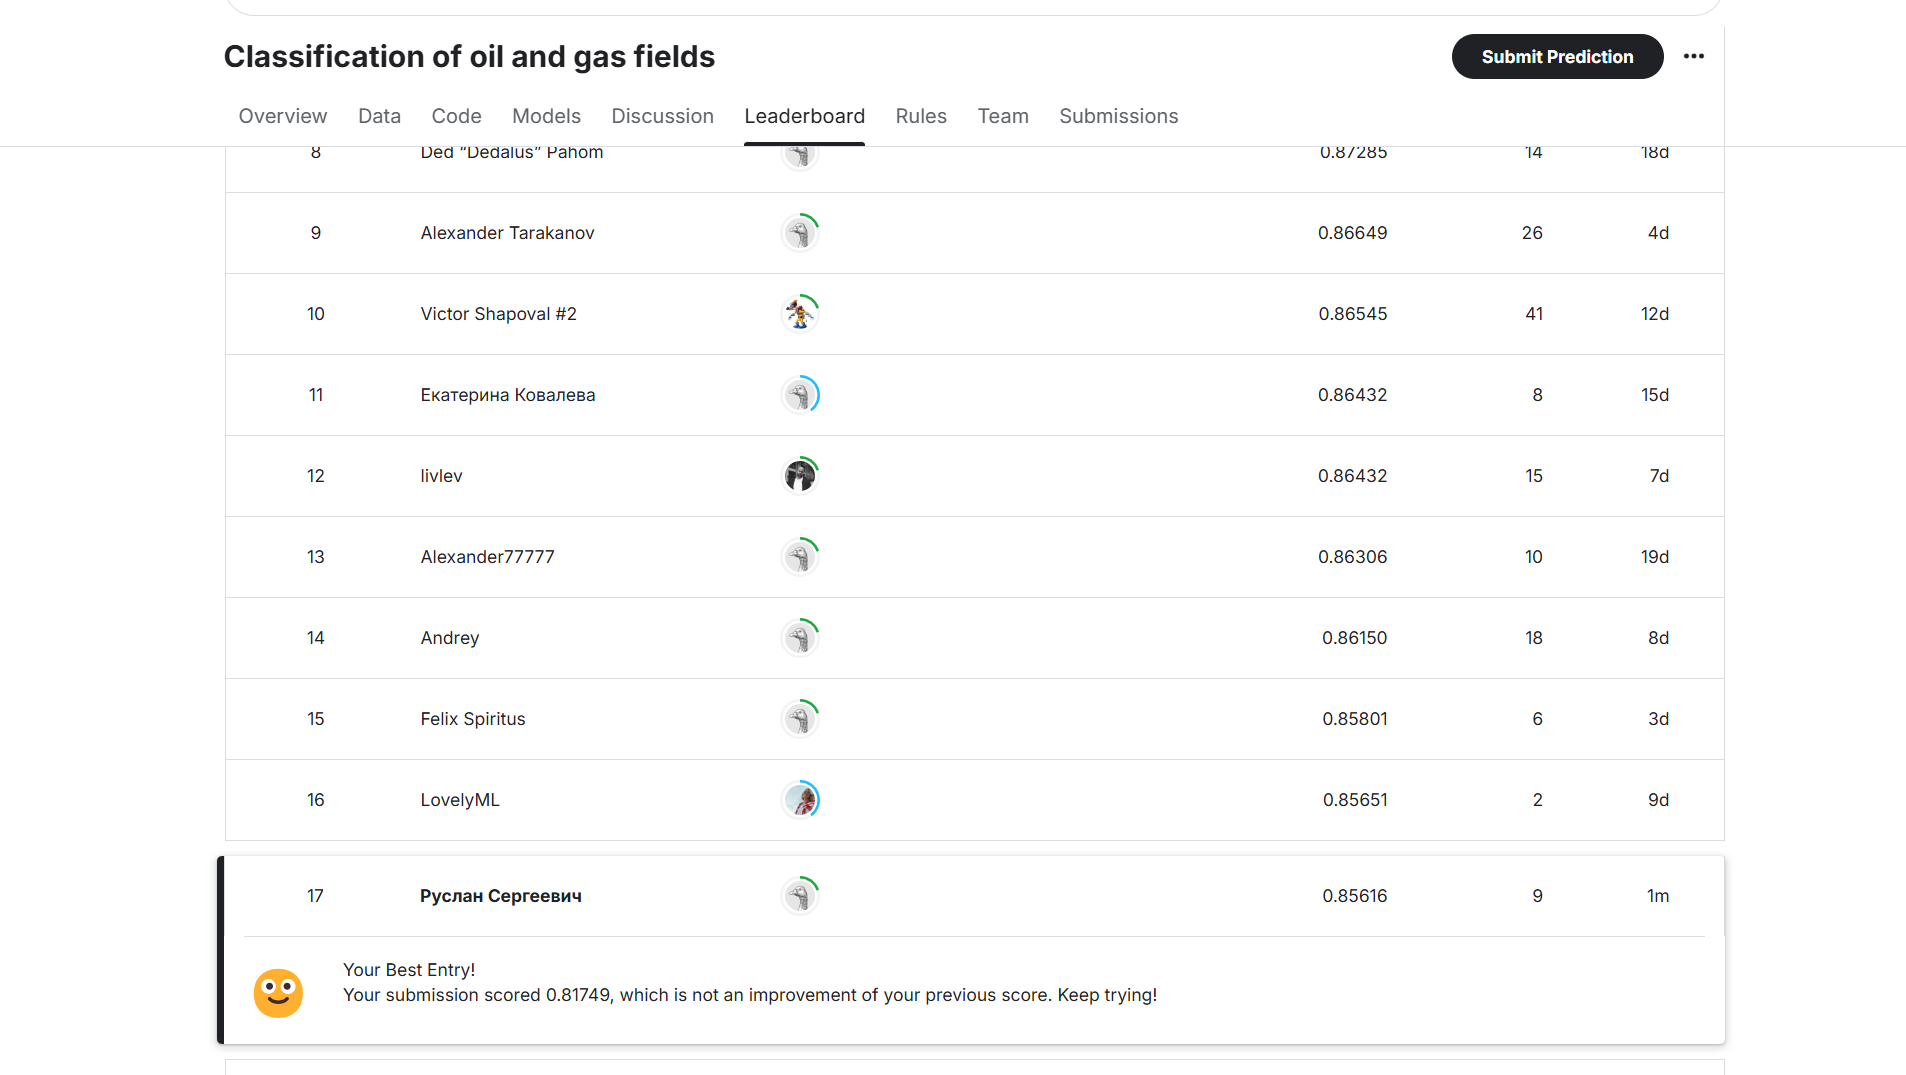